In [1]:
import pandas as pd
from pandas import datetime
# Load the dataset
file_path = 'CABK.MC.csv'
df_CABK = pd.read_csv(file_path)

<ipython-input-1-ce653be8357e>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# Check for missing values
df_CABK.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [3]:
df_CABK = df_CABK.interpolate(method='linear', limit_direction='both', axis=0)

In [4]:
# Convert the 'Date' column to datetime if it's not already
df_CABK['Date'] = pd.to_datetime(df_CABK['Date'])

# Set the 'Date' column as the index
df_CABK.set_index('Date', inplace=True)

In [5]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Create a new dataframe with only the 'Close' column and convert it to numpy array
df_close_CABK = df_CABK['Close'].values.reshape(-1, 1)

# Normalize the 'OHLC_Avg' values
scaled_df_close_CABK = scaler.fit_transform(df_close_CABK)

In [7]:
# Define the size of the training dataset
train_size_CABK = int(len(scaled_df_close_CABK) * 0.8)

# Split the data into training and testing datasets
train_CABK, test_CABK = scaled_df_close_CABK[0:train_size_CABK, :], scaled_df_close_CABK[train_size_CABK:len(scaled_df_close_CABK), :]

In [8]:
import numpy as np

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Create training and testing datasets
look_back = 1
trainX_CABK, trainY_CABK = create_dataset(train_CABK, look_back)
testX_CABK, testY_CABK = create_dataset(test_CABK, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX_CABK, (trainX_CABK.shape[0], 1, trainX_CABK.shape[1]))
testX = np.reshape(testX_CABK, (testX_CABK.shape[0], 1, testX_CABK.shape[1]))

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

# Specify the learning rate
learning_rate = 0.001

# Initialize the LSTM model
model_CABK = Sequential()

# Add LSTM layer
model_CABK.add(LSTM(4, input_shape=(1, look_back)))

# Add output layer
model_CABK.add(Dense(1))

# Create an instance of the Adam optimizer with the specified learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the custom optimizer
model_CABK.compile(loss='mean_squared_error', optimizer=adam_optimizer)

In [10]:
# Train the model
model_CABK.fit(trainX_CABK, trainY_CABK, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
2046/2046 [==============================] - 5s 2ms/step - loss: 0.0320
Epoch 2/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.5904e-04
Epoch 3/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.2986e-04
Epoch 4/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.2313e-04
Epoch 5/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.1342e-04
Epoch 6/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.1162e-04
Epoch 7/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.0094e-04
Epoch 8/100
2046/2046 [==============================] - 3s 2ms/step - loss: 3.9866e-04
Epoch 9/100
2046/2046 [==============================] - 3s 2ms/step - loss: 4.0574e-04
Epoch 10/100
2046/2046 [==============================] - 3s 2ms/step - loss: 3.9499e-04
Epoch 11/100
2046/2046 [==============================] - 4s 2ms/step - loss: 4.1613e-04
Epoch 12/100
2046/2046 [==========

In [11]:
# Evaluate the model
loss_CABK = model_CABK.evaluate(testX_CABK, testY_CABK, verbose=0)
print(f"Test Loss: {loss_CABK}")

Test Loss: 0.0004222376155667007


In [12]:
import matplotlib.pyplot as plt

# Make predictions
testPredict_CABK = model_CABK.predict(testX_CABK)

# Invert predictions back to original scale
testPredict_CABK = scaler.inverse_transform(testPredict_CABK)
testY_CABK = scaler.inverse_transform([testY_CABK])

16/16 [==============================] - 0s 1ms/step


In [13]:
from sklearn.metrics import mean_squared_error
# Flatten the arrays
testPredict_CABK_flat = testPredict_CABK.flatten()
testY_CABK_flat = testY_CABK.flatten()

# Check the shapes
print(f'Shape of testY_CABK: {testY_CABK_flat.shape}')
print(f'Shape of testPredict_CABK: {testPredict_CABK_flat.shape}')

# Ensure that the shapes are the same before calculating the metrics
if testY_CABK_flat.shape == testPredict_CABK_flat.shape:
    # Calculate MSE
    mse = mean_squared_error(testY_CABK_flat, testPredict_CABK_flat)
    print(f'Mean Squared Error (MSE): {mse}')

    # Calculate RMSE
    rmse = np.sqrt(mse)
    print(f'Root Mean Squared Error (RMSE): {rmse}')

    # Calculate MAPE
    mape = np.mean(np.abs((testY_CABK_flat - testPredict_CABK_flat) / testY_CABK_flat)) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
else:
    print("Error: The shapes of testY_CABK and testPredict_CABK do not match.")


Shape of testY_CABK: (510,)
Shape of testPredict_CABK: (510,)
Mean Squared Error (MSE): 0.00488681064081696
Root Mean Squared Error (RMSE): 0.0699057268098756
Mean Absolute Percentage Error (MAPE): 1.5635206359849223%


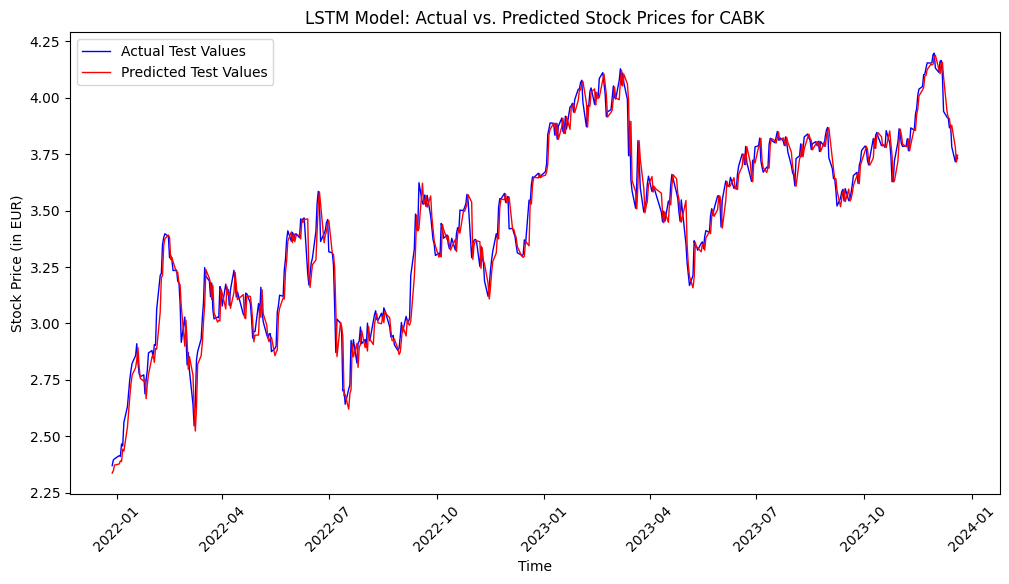

In [14]:
# Extract dates corresponding to the test data
test_dates = df_CABK.index[train_size_CABK + look_back + 1:len(df_CABK)]

# Plotting the test predictions
plt.figure(figsize=(12,6))
plt.plot(test_dates, testY_CABK_flat, label='Actual Test Values', color='blue', linewidth=1)
plt.plot(test_dates, testPredict_CABK_flat, label='Predicted Test Values', color='red', linewidth=1)
plt.title('LSTM Model: Actual vs. Predicted Stock Prices for CABK')
plt.xlabel('Time')
plt.ylabel('Stock Price (in EUR)')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.show()

